# Implementacion de filtros FIR from scratch

En este notebook se explicara la implementacion de filtros de topologia FIR desde cero

## Topologia

La topologia de los filtros FIR (Finite Impulse Response) se centra unicamente en la acumulacion ponderada de los valores anteriores de la entrada, mediante la siguiente ecuacion:

$$y_n = \sum_{k=0}^{N-1}{b_k x_{n-k}} = \sum_{k=0}^{N-1}{h_k x_{n-k}}$$

la expresion $N-1$ representa el orden del filtro, los terminos $b_k$ representan la respuesta al impulso del filtro.

Al aplicar la transformada Z a esta ecuacion queda como:

$$H(z) = \sum_{k=0}^{N-1}{h_k z^{-k}} = h_0 + h_1 z^{-1} + ... + h_{N-1}z^{-(N-1)}$$

![FIR](images/FIR_estr.PNG)

# Aproximaciones de los filtros

|Tipo de filtro | $h_D(n), n\neq 0$ | $h_D(0)$ |
|---------------|-------------------|----------|
| Pasa bajo | $2f_c\cdot sinc(n\omega_c)$ | $2f_c$ |
| Pasa alto | $-2f_c\cdot sinc(n\omega_c)$ | $1-2f_c$ |
| Pasa banda | $2f_a\cdot sinc(n\omega_a)-2f_b\cdot sinc(n\omega_b)$ | $2(f_a-f_b)$ |
| Para banda | $2f_b\cdot sinc(n\omega_b)-2f_a\cdot sinc(n\omega_a)$ | $1-2(f_a-f_b)$ |

## Tipos de ventanas

![FIR](images/ventanas.jpeg)

# Implementacion del filtro from Scratch



### Carga de librerias

In [1]:
# Carga de librerias para implementacion
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft
from scipy.signal import firwin, lfilter
from scipy import signal

### Definicion de las especificaciones del filtro a implementar

En esta seccion se colocaran los valores de referencia, el mas importante es la frecuencia de corte, esta se debe colocar generalmente en estala normalizada `(0-1)` dependiendo de la frecuencia normalizada respecto a $\pi$ y a la frecuencia de muestreo

La ecuacion para calcular la frecuencia normalizada es:

$$fc = \frac{fc_{real}}{fs/2}$$



In [2]:
def hanning_window(N): 
    '''
    Funcion para crear una ventana tipo Hanning
    '''
    n = np.arange(N)
    return 0.5 - 0.5 * np.cos(2 * np.pi * n / (N))

Text(0.5, 1.0, 'Ventana tipo Hanning')

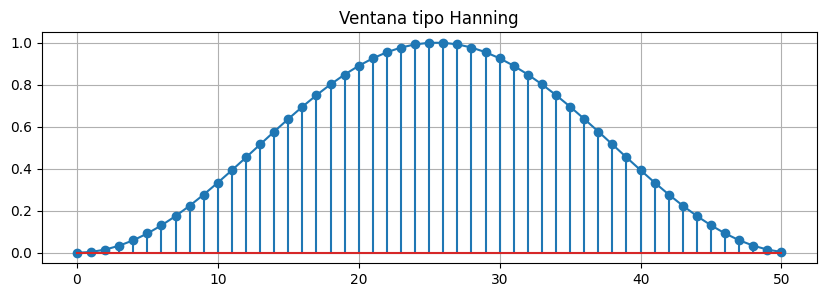

In [3]:
# Definir las especificaciones del filtro
fc = 0.25  # Normalizada (0.5 corresponde a la frecuencia de Nyquist)
n_coef = 51   # Número de coeficientes (impares para un filtro simétrico)
w_type = 'hann'  # Tipo de ventana

ventana = signal.get_window(w_type, n_coef) # Extraccion de ventana tipo hanning
win = hanning_window(n_coef)

plt.figure(figsize=(10,3))
plt.plot(ventana)
plt.stem(win)
plt.grid()
plt.title('Ventana tipo Hanning')

### Calculo de la respuesta ideal al impulso

La respuesta ideal al impulso es la funcion:

$$sinc(x) = \frac{sin(x)}{x}$$

Esta respuesta es infinita y es necesario truncarla. Para truncarla elegimos en numero $N$ de coeficientes tal como se produjo en la ventana anterior

La respuesta ideal al impulso se calcula como:

$$h_d[n]=f_c \cdot sinc(f_c\cdot(n-(N-1)/2))$$

Luego, el filtro queda disenado como el producto de la respuesta ideal al impulso y la ventana asi:

$$h[n]=h_d[n]\cdot w[n]$$

In [4]:
def sinc(x):
    '''
    Creacion de funcion sinc
    '''
    return np.where(x == 0, 1, np.sin(np.pi * x) / (np.pi*x))

def ideal_lowpass(fc, N):
    n = np.arange(N)
    return fc * sinc(fc * (n - (N-1) / 2))

/var/folders/89/43ylvgyx5hj4v_z5nn_dl1980000gn/T/ipykernel_7547/739796277.py:5: RuntimeWarning: invalid value encountered in divide
  return np.where(x == 0, 1, np.sin(np.pi * x) / (np.pi*x))


Text(0.5, 1.0, 'Respuesta en frecuencia')

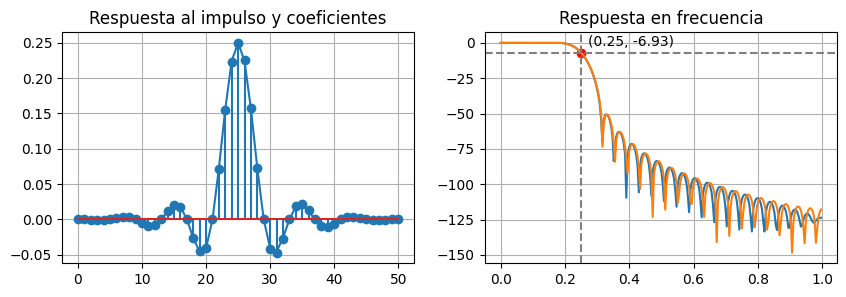

In [5]:
# Calcular los coeficientes del filtro
coefs_ideal = ideal_lowpass(fc, n_coef) # Coeficientes ideales
coefs_scr = coefs_ideal * win # Cultiplicacion de la respuesta al impulso y la ventana

coefs_lib = firwin(n_coef, fc, window=w_type, pass_zero='lowpass') # Coeficientes libreria

# Guardar coeficientes
df = pd.DataFrame(np.array([coefs_scr, coefs_lib]).T, columns=('scr', 'lib'))
df.to_csv('low_0_25.csv', index=False)

# Calcular la respuesta en frecuencia del filtro
n_size = 512 # tamano de la transformada de Fourier

H_scr = fft(coefs_scr, n= n_size)
H_scr =  (20*np.log((np.abs(H_scr)))/2)[0:int(n_size/2)]

H_lib = fft(coefs_lib, n= n_size)
H_lib =  (20*np.log((np.abs(H_lib)))/2)[0:int(n_size/2)]

fh = np.arange(0,1,1/int(n_size/2))

punto_x = fc
punto_y = np.round(np.interp(punto_x, fh, H_scr),2)


# Graficacion de la respuesta del filtro
plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.plot(coefs_lib)
plt.stem(coefs_scr)
plt.grid()
plt.title('Respuesta al impulso y coeficientes')
plt.subplot(1,2,2)
plt.plot(fh,H_scr)
plt.plot(fh,H_lib)
plt.scatter(punto_x, punto_y, color='red', label=f'Punto ({punto_x}, {punto_y})')
plt.annotate(f'({punto_x}, {punto_y})', (punto_x, punto_y), textcoords="offset points", xytext=(5,5), ha='left')
# Líneas de marcadores para el punto
plt.axvline(x=punto_x, color='gray', linestyle='--')
plt.axhline(y=punto_y, color='gray', linestyle='--')


plt.grid()
plt.title('Respuesta en frecuencia')


In [6]:
ar = coefs_scr

### Prueba de funcionamiento del filtro

Se sinteizara una senal seno con 3 frecuencias para probar 3 tipos de filtros, pasa bajas, pasa altas y pasa banda.

Luego evaluaremos el espectro de fourier de la senal de entrada y la senal de salida.

Text(0.5, 1.0, 'Señal original')

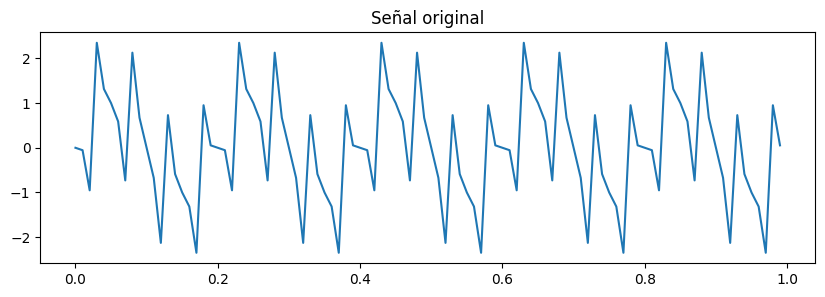

In [7]:
fs = 100 # frecuencia de muestreo en hertz
f1 = 0.05 * fs 
f2 = 0.4 * fs
f3 = 0.8 * fs
t = np.arange(0, 1, 1/fs) # vector de tiempo

senal = np.sin(2 * np.pi * f1 * t) + np.sin(2 * np.pi * f2 * t) + np.sin(2 * np.pi * f3 * t)

plt.figure(figsize=(10,3))
plt.plot(t,senal)
plt.title("Señal original")

## Aplicacion del filtro

Aplicaremos el filtro usando librerias y la ecuacion en diferencias


Crearemos una funcion para aplicar el filtro por ecuacion en diferencias

In [8]:
def filtro_fir(senal, coeficientes):
    N = len(coeficientes)
    senal_filtrada = np.zeros_like(senal)

    # Aplicamos la ecuacion en diferencias
    for n in range(len(senal)):
        for k in range(N):
            if n - k >= 0: # asegurarse de que el indice no sea negativo
                senal_filtrada[n] += coeficientes[k] * senal[n - k]

    return senal_filtrada

Text(0, 0.5, 'Amplitud')

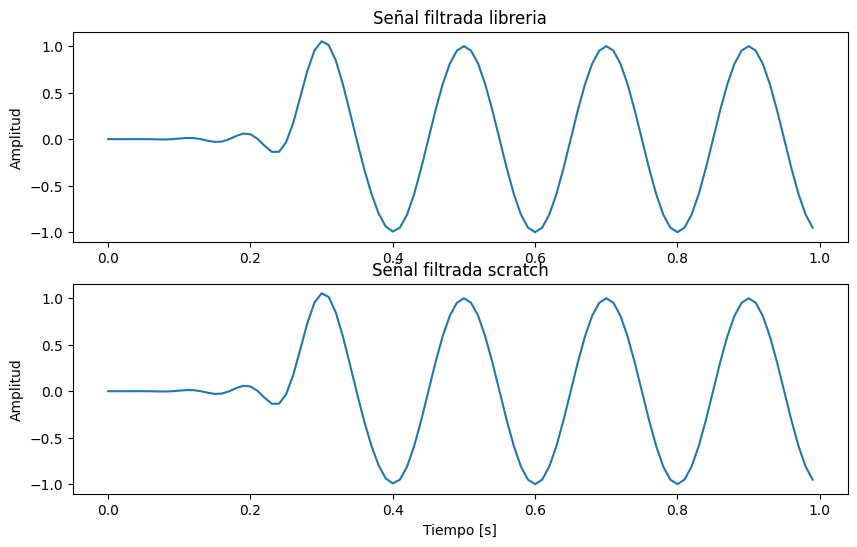

In [9]:
# Aplicar el filtro a los datos
filt_lib = lfilter(coefs_lib, 1, senal)
filt_scr = filtro_fir(senal, coefs_scr)

# Visualización
plt.figure(figsize=(10, 6))

# Señal filtrada libreria
plt.subplot(2, 1, 1)
plt.plot(t, filt_lib)
plt.title('Señal filtrada libreria')
#plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')

# Señal filtrada scratch
plt.subplot(2, 1, 2)
plt.plot(t, filt_scr)
plt.title('Señal filtrada scratch')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')


### Analisis de fourier

Aplicaremos la transformada de Fourier para extraer la informacion frecuencial de las senales

/Users/fabiancastano/Desktop/FiltrosFIR/env/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:2017: UserWarning: nperseg = 256 is greater than input length  = 100, using nperseg = 100
  warnings.warn('nperseg = {0:d} is greater than input length '


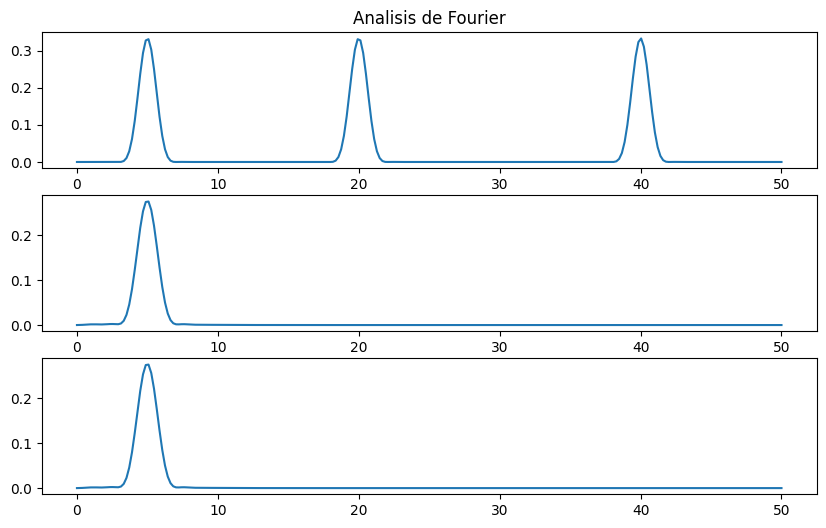

In [10]:
f_welch, F_ori = signal.welch(senal,fs,nfft=512)
f_welch, F_lib = signal.welch(filt_lib,fs,nfft=512)
f_welch, F_scr = signal.welch(filt_scr,fs,nfft=512)

plt.figure(figsize=(10,6))
plt.subplot(3,1,1)
plt.plot(f_welch,F_ori)
plt.title("Analisis de Fourier")
plt.subplot(3,1,2)
plt.plot(f_welch,F_lib)
plt.subplot(3,1,3)
plt.plot(f_welch,F_scr)

# Filtro pasa altas

El filtro pasa altas se calcula mediante inversion espectral, en este caso se calcula la respuesta al impulso de un filtro pasa bajas, luego se invierte (multiplica por $-1$) y finalmente el coeficiente central se le suma $1$

In [11]:
# Convertir a filtro pasa altas mediante inversión espectral
def convert_to_highpass(coeficientes):
    coeficientes_highpass = -coeficientes
    centro = len(coeficientes) // 2
    coeficientes_highpass[centro] += 1
    return coeficientes_highpass

# Convertir a filtro pasa altas mediante inversión espectral
def ideal_highpass(fc, N):
    n = np.arange(N)
    filt = - fc * sinc(fc * (n - (N - 1) / 2))
    filt[N // 2] = 1- fc
    return filt

## Diseno de filtro pasa altas


Text(0.5, 1.0, 'Ventana tipo Hanning')

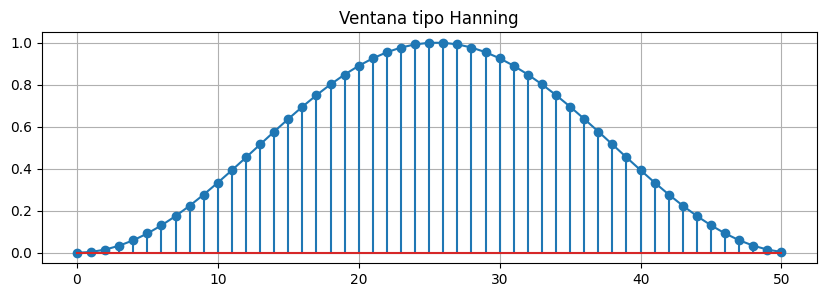

In [12]:
# Definir las especificaciones del filtro
fc = 0.6  # Normalizada (0.5 corresponde a la frecuencia de Nyquist)
n_coef = 51   # Número de coeficientes (impares para un filtro simétrico)
w_type = 'hann'  # Tipo de ventana

ventana = signal.get_window(w_type, n_coef) # Extraccion de ventana tipo hanning
win = hanning_window(n_coef)

plt.figure(figsize=(10,3))
plt.plot(ventana)
plt.stem(win)
plt.grid()
plt.title('Ventana tipo Hanning')

/var/folders/89/43ylvgyx5hj4v_z5nn_dl1980000gn/T/ipykernel_7547/739796277.py:5: RuntimeWarning: invalid value encountered in divide
  return np.where(x == 0, 1, np.sin(np.pi * x) / (np.pi*x))


Text(0.5, 1.0, 'Respuesta en frecuencia')

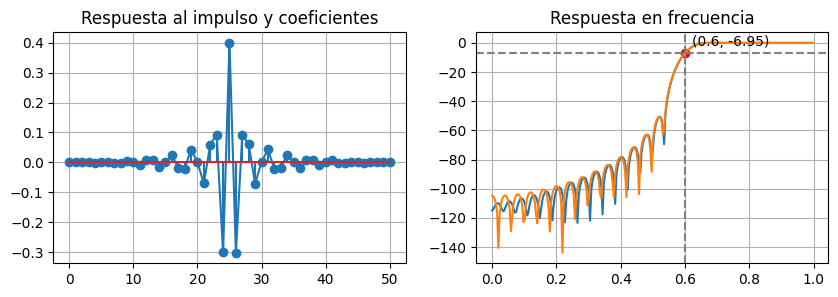

In [13]:
# Calcular los coeficientes del filtro
#coefs_ideal = ideal_lowpass(fc, n_coef) # Coeficientes ideales
#coefs_scr = coefs_ideal * win # Cultiplicacion de la respuesta al impulso y la ventana
#coefs_scr = convert_to_highpass(coefs_scr)

coefs_ideal = ideal_highpass(fc, n_coef) # Coeficientes ideales
coefs_scr = coefs_ideal * win # Cultiplicacion de la respuesta al impulso y la ventana

coefs_lib = firwin(n_coef, fc, window=w_type, pass_zero='highpass') # Coeficientes libreria

# Guardar coeficientes
df = pd.DataFrame(np.array([coefs_scr, coefs_lib]).T, columns=('scr', 'lib'))
df.to_csv('high_0_6.csv', index=False)

# Calcular la respuesta en frecuencia del filtro
n_size = 512 # tamano de la transformada de Fourier

H_scr = fft(coefs_scr, n= n_size)
H_scr =  (20*np.log((np.abs(H_scr)))/2)[0:int(n_size/2)]

H_lib = fft(coefs_lib, n= n_size)
H_lib =  (20*np.log((np.abs(H_lib)))/2)[0:int(n_size/2)]

fh = np.arange(0,1,1/int(n_size/2))

punto_x = fc
punto_y = np.round(np.interp(punto_x, fh, H_scr),2)


# Graficacion de la respuesta del filtro
plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.plot(coefs_lib)
plt.stem(coefs_scr)
plt.grid()
plt.title('Respuesta al impulso y coeficientes')
plt.subplot(1,2,2)
plt.plot(fh,H_scr)
plt.plot(fh,H_lib)
plt.scatter(punto_x, punto_y, color='red', label=f'Punto ({punto_x}, {punto_y})')
plt.annotate(f'({punto_x}, {punto_y})', (punto_x, punto_y), textcoords="offset points", xytext=(5,5), ha='left')
# Líneas de marcadores para el punto
plt.axvline(x=punto_x, color='gray', linestyle='--')
plt.axhline(y=punto_y, color='gray', linestyle='--')


plt.grid()
plt.title('Respuesta en frecuencia')

Text(0, 0.5, 'Amplitud')

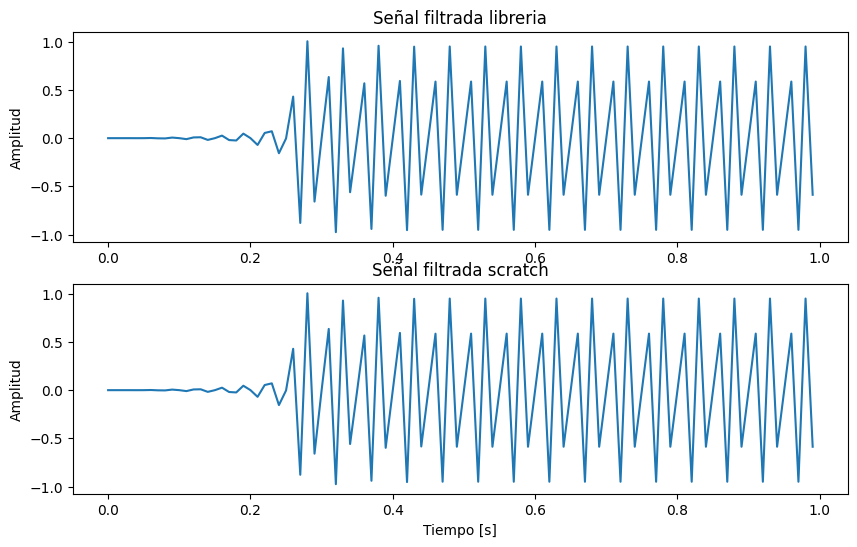

In [14]:
# Aplicar el filtro a los datos
filt_lib = lfilter(coefs_lib, 1, senal)
filt_scr = filtro_fir(senal, coefs_scr)

# Visualización
plt.figure(figsize=(10, 6))

# Señal filtrada libreria
plt.subplot(2, 1, 1)
plt.plot(t, filt_lib)
plt.title('Señal filtrada libreria')
#plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')

# Señal filtrada scratch
plt.subplot(2, 1, 2)
plt.plot(t, filt_scr)
plt.title('Señal filtrada scratch')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')

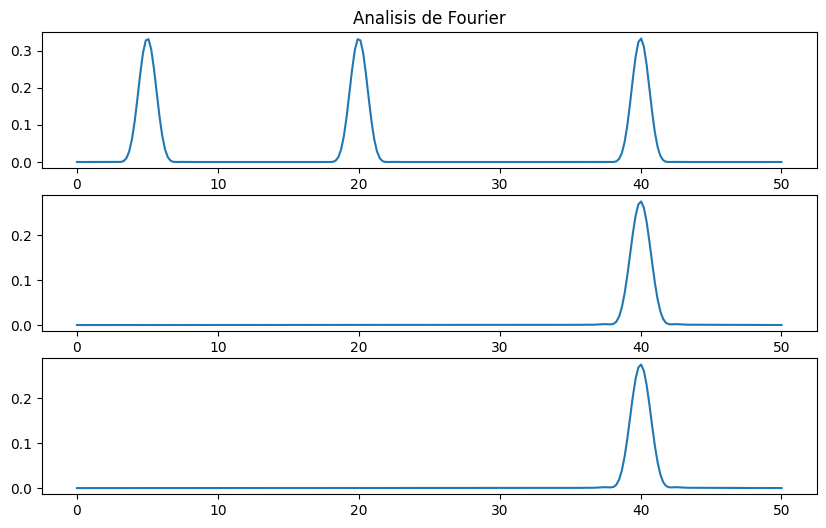

In [15]:
f_welch, F_ori = signal.welch(senal,fs,nfft=512)
f_welch, F_lib = signal.welch(filt_lib,fs,nfft=512)
f_welch, F_scr = signal.welch(filt_scr,fs,nfft=512)

plt.figure(figsize=(10,6))
plt.subplot(3,1,1)
plt.plot(f_welch,F_ori)
plt.title("Analisis de Fourier")
plt.subplot(3,1,2)
plt.plot(f_welch,F_lib)
plt.subplot(3,1,3)
plt.plot(f_welch,F_scr)

# Filtro pasa banda

Para este filtro se toma la combinacion de la respuesta de los dos filtros anteriores

https://es.wikipedia.org/wiki/Diseño_de_Filtros_de_Respuesta_Finita_al_Impulso

In [16]:
# Convertir a filtro pasa altas mediante inversión espectral
def ideal_bandpass(fca, fcb, N):
    n = np.arange(N)
    filt = fca * sinc(fca * (n - (N - 1) / 2)) - fcb * sinc(fcb * (n - (N - 1) / 2))
    filt[N // 2] = (fca - fcb)
    return filt
    

Text(0.5, 1.0, 'Ventana tipo Hanning')

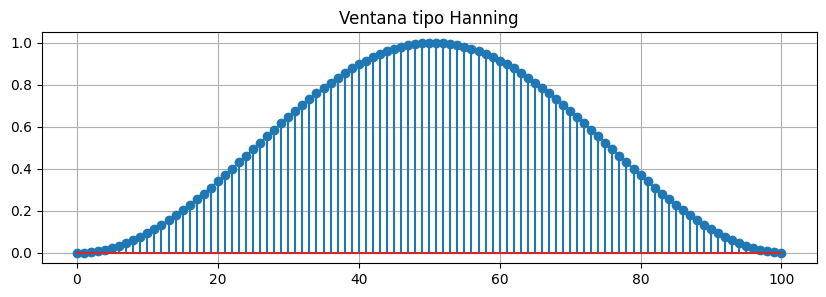

In [17]:
# Definir las especificaciones del filtro
fc1 = 0.2  # Normalizada (0.5 corresponde a la frecuencia de Nyquist)
fc2 = 0.5  # Normalizada (0.5 corresponde a la frecuencia de Nyquist)
n_coef = 101   # Número de coeficientes (impares para un filtro simétrico)
w_type = 'hann'  # Tipo de ventana

ventana = signal.get_window(w_type, n_coef) # Extraccion de ventana tipo hanning
win = hanning_window(n_coef)

plt.figure(figsize=(10,3))
plt.plot(ventana)
plt.stem(win)
plt.grid()
plt.title('Ventana tipo Hanning')

/var/folders/89/43ylvgyx5hj4v_z5nn_dl1980000gn/T/ipykernel_7547/739796277.py:5: RuntimeWarning: invalid value encountered in divide
  return np.where(x == 0, 1, np.sin(np.pi * x) / (np.pi*x))


Text(0.5, 1.0, 'Respuesta en frecuencia')

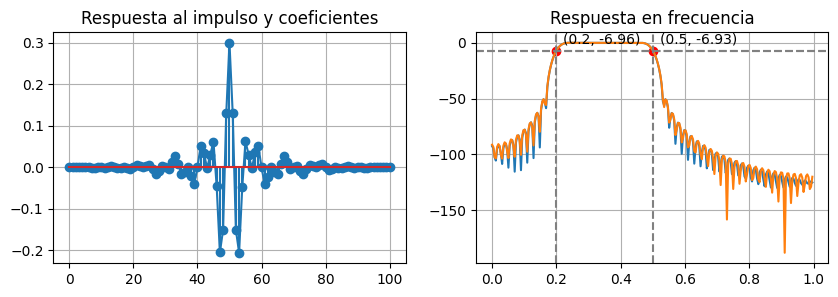

In [18]:
# Calcular los coeficientes del filtro
coefs_ideal = ideal_bandpass(fc2, fc1, n_coef) # Coeficientes ideales
coefs_scr = coefs_ideal * win # Cultiplicacion de la respuesta al impulso y la ventana

coefs_lib = firwin(n_coef, (fc1, fc2), window=w_type, pass_zero='bandpass') # Coeficientes libreria

# Guardar coeficientes
df = pd.DataFrame(np.array([coefs_scr, coefs_lib]).T, columns=('scr', 'lib'))
df.to_csv('band_0_2__0_5.csv', index=False)

# Calcular la respuesta en frecuencia del filtro
n_size = 512 # tamano de la transformada de Fourier

H_scr = fft(coefs_scr, n= n_size)
H_scr =  (20*np.log((np.abs(H_scr)))/2)[0:int(n_size/2)]

H_lib = fft(coefs_lib, n= n_size)
H_lib =  (20*np.log((np.abs(H_lib)))/2)[0:int(n_size/2)]

fh = np.arange(0,1,1/int(n_size/2))

punto_x1 = fc1
punto_y1 = np.round(np.interp(punto_x1, fh, H_scr),2)
punto_x2 = fc2
punto_y2 = np.round(np.interp(punto_x2, fh, H_scr),2)


# Graficacion de la respuesta del filtro
plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.plot(coefs_lib)
plt.stem(coefs_scr)
plt.grid()
plt.title('Respuesta al impulso y coeficientes')
plt.subplot(1,2,2)
plt.plot(fh,H_scr)
plt.plot(fh,H_lib)
plt.scatter(punto_x1, punto_y1, color='red', label=f'Punto ({punto_x1}, {punto_y1})')
plt.annotate(f'({punto_x1}, {punto_y1})', (punto_x1, punto_y1), textcoords="offset points", xytext=(5,5), ha='left')
plt.scatter(punto_x2, punto_y2, color='red', label=f'Punto ({punto_x2}, {punto_y2})')
plt.annotate(f'({punto_x2}, {punto_y2})', (punto_x2, punto_y2), textcoords="offset points", xytext=(5,5), ha='left')
# Líneas de marcadores para el punto
plt.axvline(x=punto_x1, color='gray', linestyle='--')
plt.axhline(y=punto_y1, color='gray', linestyle='--')
plt.axvline(x=punto_x2, color='gray', linestyle='--')
plt.axhline(y=punto_y2, color='gray', linestyle='--')


plt.grid()
plt.title('Respuesta en frecuencia')

Text(0, 0.5, 'Amplitud')

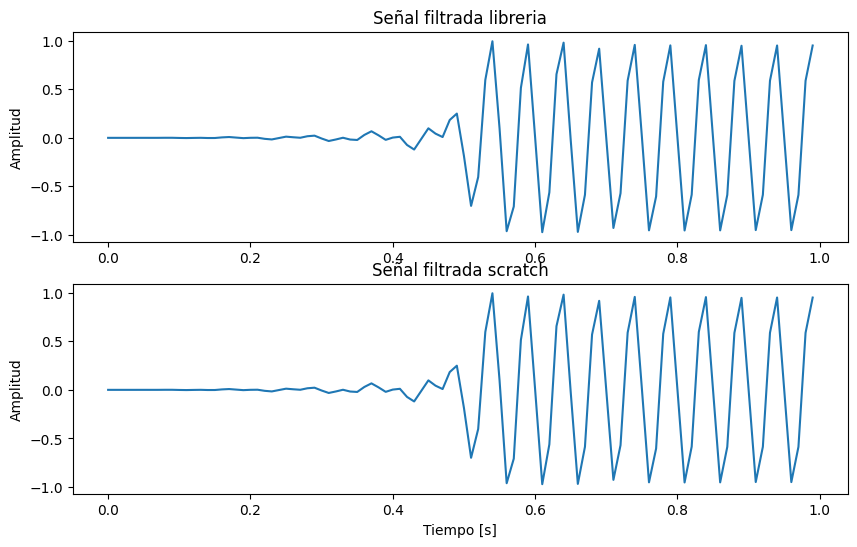

In [19]:
# Aplicar el filtro a los datos
filt_lib = lfilter(coefs_lib, 1, senal)
filt_scr = filtro_fir(senal, coefs_scr)

# Visualización
plt.figure(figsize=(10, 6))

# Señal filtrada libreria
plt.subplot(2, 1, 1)
plt.plot(t, filt_lib)
plt.title('Señal filtrada libreria')
#plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')

# Señal filtrada scratch
plt.subplot(2, 1, 2)
plt.plot(t, filt_scr)
plt.title('Señal filtrada scratch')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')

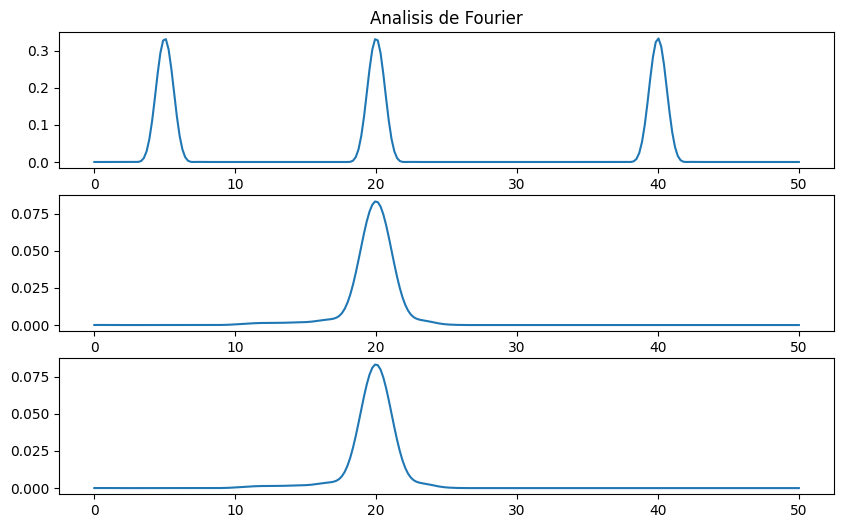

In [20]:
f_welch, F_ori = signal.welch(senal,fs,nfft=512)
f_welch, F_lib = signal.welch(filt_lib,fs,nfft=512)
f_welch, F_scr = signal.welch(filt_scr,fs,nfft=512)

plt.figure(figsize=(10,6))
plt.subplot(3,1,1)
plt.plot(f_welch,F_ori)
plt.title("Analisis de Fourier")
plt.subplot(3,1,2)
plt.plot(f_welch,F_lib)
plt.subplot(3,1,3)
plt.plot(f_welch,F_scr)